# analyse.py - maanas' version

Created on Mon Oct 30 14:06:37 2023

@author: Maanas

Credit to Elias Fink, Laura Hollister, my classmates and lab demonstrators for helping develop parts of this code


# Notebook overview:
Part 1: Crossing points analysis using raw interferogram data; ideally use reference data, here this it the green filtered mercury beam; correcting spectrum using green line as reference

Part 2: Shift the points so there is equal spacing (fft set up + cubic spline); this is a step needed for FFT.

Part 3: FFT of corrected interferogram data to get Spectrum

Part 4: Plots + Analysis

Part 5: Advanced Analysis + Plotting using curve fits


This notebook has been created in a way such that the user only needs to import their data and ensure the conventions/variable names are consistent. Following this, the code should require no change and all analysis should follow automatically.

# Part 1 - crossing point analysis
Find distance between nodes (where amplitude = 0 ) of interferogram data

Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.fftpack as spf
import scipy.interpolate as spi
import pandas as pd
import scipy.optimize as op
import seaborn as sns
import plotly.express as px

# Import the data

from tkinter.filedialog import askopenfilename
filename = askopenfilename()
# file = open(filename,'r')
# data = file.read()

# filename = 'Task14-2.txt'  # change this to your filename
# y_ref and y_data may be the other way around depending on which
# beamsplitter has the green reference laser going into it. If you see a single peak at the green line wavelength, swap y_ref and y_data here.

y_data, y_ref, x_measured = np.loadtxt(filename, unpack=True, usecols=(0, 1,5), max_rows = 80000, skiprows = 451)

# Set the reference wavelength in units of nm, here the reference wavelength is the the grren spectral line
ref_wl = 546.0735/2  # factor 2 as each crossing = half lambda
sampling_frequency = 50  # frequency, in Hz
x = 0.7 * np.arange(0, len(y_ref), 1)/sampling_frequency
# x is distance travelled by motor


Using a Butterworth filter as a high-pass filter and removing offsets

In [2]:
# Remove offsets, and the butterworth filter to correct for misaligment
y_ref -= y_ref.mean()  # remove offsets
y_data -= y_data.mean()

filter_order = 2
freq = 1  # cutoff frequency
sampling = 50  # sampling frequency
sos = signal.butter(filter_order, freq, 'hp', fs=sampling, output='sos')
y_ref = signal.sosfilt(sos, y_ref)  # filter the y values
y_data = signal.sosfilt(sos, y_data)

Find crossing points - used for analysis later

In [3]:
# find the crossing points for analysis later
crossing_points = []
for i in range(len(y_ref)-1):
    if (y_ref[i] <= 0 and y_ref[i+1] >= 0) or (y_ref[i] >= 0 and y_ref[i+1] <= 0):
        b = (x[i] * y_ref[i+1] - x[i+1] * y_ref[i]) / (x[i] - x[i+1])
        a = (y_ref[i+1] - b)/x[i+1]
        extra = -b/a - x[i]
        crossing_points = np.append(crossing_points, (x[i]+extra)) # interpolate crossing point

diff = np.array([])
for i in range(len(crossing_points)-1):
    diff = np.append(diff, (np.abs(crossing_points[i+1]-crossing_points[i])))


Find crossing points - used to get micrometer:mirror ratio

In [4]:
# find the crossing points to find micrometer-mirror ratio
crossing_points2 = []
for i in range(len(y_ref)-1):
    if (y_ref[i] <= 0 and y_ref[i+1] >= 0) or (y_ref[i] >= 0 and y_ref[i+1] <= 0):
        b = (x_measured[i] * y_ref[i+1] - x_measured[i+1] * y_ref[i]) / (x_measured[i] - x_measured[i+1])
        a = (y_ref[i+1] - b)/x_measured[i+1]
        extra = -b/a - x_measured[i]
        crossing_points2 = np.append(crossing_points2, (x_measured[i]+extra)) # interpolate crossing point

diff2 = np.array([])
for i in range(len(crossing_points2)-1):
    diff2 = np.append(diff2, (np.abs(crossing_points2[i+1]-crossing_points2[i])))


print("The mean difference between crossing points is %.0d and the standard deviation between crossing points is %.0d" % (np.mean(diff2),np.std(diff2)))


The mean difference between crossing points is 7151 and the standard deviation between crossing points is 199


Get ratio and find associated error

In [5]:
mean_diff = np.mean(diff2)
wl_musteps = 4*mean_diff  # wavelength in musteps ~was 2 originally
wl_real = 546.0735  # from laser specifications

dist_per_mustep = wl_real / wl_musteps

print('Distance moved per mu step is %.6f nm' % (dist_per_mustep))

# find distance measured wavelength and relevant error
mean_diff_nm = mean_diff/64
measured_wavelength = mean_diff_nm*4 
print("Measured wavelength (based on the approximate calculations) is %.2f nm"%(measured_wavelength))

error = np.absolute(wl_real-measured_wavelength)*100/measured_wavelength
print("The percentage error is %.2f%%" % (error))


Distance moved per mu step is 0.019089 nm
Measured wavelength (based on the approximate calculations) is 446.97 nm
The percentage error is 22.17%


Plots

C:\Users\Maanas\AppData\Local\Temp\ipykernel_7216\840847503.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax[0].plot(crossing_points, 0*np.array(crossing_points),'go', label='Crossing Points', color='tab:red')
C:\Users\Maanas\AppData\Local\Temp\ipykernel_7216\840847503.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  ax[1].plot(crossing_points, 0*np.array(crossing_points),'go', label='Crossing Points', color='tab:red')


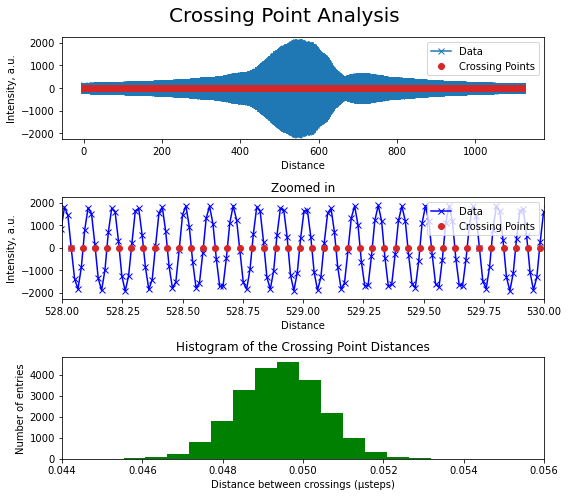

In [6]:
# plot crossing points (comment this section out if you don't want the graph)

fig, ax = plt.subplots(3, 1, figsize=(8, 7))
fig.suptitle('Crossing Point Analysis', fontsize=20)

# ax[0].set_title("Position against Signal")
ax[0].plot(x, y_ref, 'x-', label='Data')
ax[0].plot(crossing_points, 0*np.array(crossing_points),'go', label='Crossing Points', color='tab:red')
ax[0].set_xlabel('Distance')
ax[0].set_ylabel('Intensity, a.u.')
ax[0].legend(loc='upper right')


ax[1].plot(x, y_ref, 'x-', label='Data', color='blue')
ax[1].plot(crossing_points, 0*np.array(crossing_points),'go', label='Crossing Points', color='tab:red')
ax[1].set_xlim(528, 530)
# ax[1].set_ylim(-300, 300)
ax[1].set_xlabel('Distance')
ax[1].set_ylabel('Intensity, a.u.')
ax[1].set_title('Zoomed in')
# ax[1].set_title('Position against Signal (zoomed in)')
ax[1].legend(loc='upper right')


ax[2].set_title('Histogram of the Crossing Point Distances')
ax[2].hist(diff, bins=100, color='green')
ax[2].set_xlabel("Distance between crossings (µsteps)")
ax[2].set_ylabel("Number of entries")
ax[2].set_xlim(0.044, 0.056)


plt.tight_layout()
plt.show()

# Part 2 - Shift the points so there is equal spacing (FFT + Cubic Spline set up)

In [7]:
index = 0
x_correct_array = []
last_pt = 0
last_pt_correct = 0

for period in range(len(crossing_points)//2-1):
    measured_lam = crossing_points[2*period+2] - crossing_points[2*period]
    shifting_ratio = ref_wl/measured_lam
    while x[index] < crossing_points[2*period+2]:
        x_correct = shifting_ratio*(x[index]-last_pt)+last_pt_correct
        x_correct_array.append(x_correct)
        index += 1
    last_pt = x[index-1]
    last_pt_correct = x_correct_array[-1]


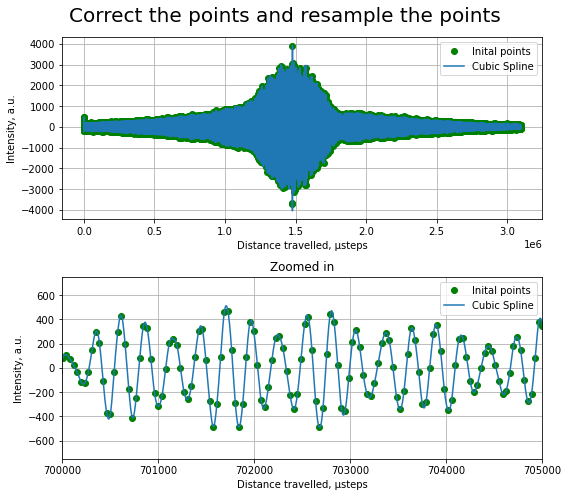

In [8]:
#  Make the Cubic Spline: these are the number of points that you will resample - try changing this and look how well the resampling follows the data.
N = 1000000  # number of data points
x_spline = np.linspace(0, x_correct_array[-1], N)  # x vals of spline points
y = y_data[:len(x_correct_array)]
cs = spi.CubicSpline(x_correct_array, y)  # cubic spline y vals

# plot corrected points and initial points for comparison
fig, ax = plt.subplots(2, 1, figsize=(8, 7))
fig.suptitle('Correct the points and resample the points', fontsize=20)

ax[0].plot(x_correct_array, y, 'go', label='Inital points')
ax[0].plot(x_spline, cs(x_spline), label="Cubic Spline")
ax[0].set_ylabel('Intensity, a.u.')
ax[0].set_xlabel('Distance travelled, µsteps')
ax[0].legend()
ax[0].grid()


ax[1].plot(x_correct_array, y, 'go', label='Inital points')
ax[1].plot(x_spline, cs(x_spline), label="Cubic Spline")
ax[1].set_ylabel('Intensity, a.u.')
ax[1].set_xlabel('Distance travelled, µsteps')
ax[1].set_title('Zoomed in')
ax[1].set_xlim(0.7e6,0.705e6)
ax[1].set_ylim(-750,750)
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

# Part 3 - FFT

List of known spectral lines

FFTs and Shifting to remove offset

In [9]:
distance = x_spline[1:]-x_spline[:-1]  # distance travelled
xf1 = spf.fftshift(spf.fftfreq(len(x_spline)))  # fourier transform and shift
# xvals turns from wavenumber to wavelength, and also use the distance to
# make the x scale nanometres
xvals = abs(2*distance.mean()/xf1[int(len(xf1)/2+1):len(xf1)])

yf1 = spf.fftshift(spf.fft(cs(x_spline)))  # fourier transform and shift
yvals = abs(yf1[int(len(xf1)/2+1):len(xf1)])  # only taking values for +ve x
yvals = yvals/max(yvals)  # normalise intensity

# Part 4: Plots + Analysis

In [10]:
#from nist
uv1 = 184.9499
uv2 = 253.6517
uv3 = 296.7280
uv4 = 365.0153
purple = 404.6563
blue = 435.8328
green = 546.0735
infrared = 1013.976
yellow1=576.9598
yellow2= 579.0663	
yellow_mean = (yellow1+yellow2)/2

#from other sources
red=691

#use above values as a guide to find ranges to search for max peaks
purple_min = 400
purple_max = 410
blue_min = 430
blue_max = 440
green_min = 540 
green_max = 550
ir_min = 1011
ir_max = 1014
yellow_min = 570
yellow_max = 585
red_min = 685
red_max = 695

Find peaks

In [11]:
purple_peak = np.max(yvals[np.where(xvals>purple_min) and np.where(xvals<purple_max)]) #
blue_peak = np.max(yvals[np.where(xvals>blue_min) and np.where(xvals<blue_max)])#
green_peak = np.max(yvals[np.where(xvals>green_min) and np.where(xvals<green_max)])#
yellow_peak1 = np.partition(yvals[np.where(xvals>yellow_min) and np.where(xvals<yellow_max)], -3)[-8] #
yellow_peak2 = np.partition(yvals[np.where(xvals>yellow_min) and np.where(xvals<yellow_max)], -2)[-14] #
ir_peak = np.partition(yvals[np.where(xvals>ir_min) and np.where(xvals<ir_max)], -2)[-23] #
# red_peak = np.partition(yvals[np.where(xvals>red_min) and np.where(xvals<red_max)], -2)[-2] #


Reverse engineer to find wavelengths

In [12]:
purple_wavelength = float(xvals[np.where(yvals == purple_peak)])
blue_wavelength = float(xvals[np.where(yvals == blue_peak)])
green_wavelength = float(xvals[np.where(yvals == green_peak)])
# yellow_wavelength1 = float(xvals[np.where(yvals == yellow_peak1)])
yellow_wavelength1 = float(xvals[np.argpartition(np.absolute(yvals-(yellow_peak1)),2)[2]])
yellow_wavelength2 = float(xvals[np.argpartition(np.absolute(yvals-(yellow_peak2)),2)[2]])

# difference_array = np.absolute(yvals-(yellow_peak1))
# diff_index = np.argpartition(difference_array,2)[2]
# print(xvals[diff_index])

# yellow_wavelength2 = float(xvals[np.where(yvals == yellow_peak2)])
ir_wavelength = float(xvals[np.where(yvals == ir_peak)])
# red_wavelength = xvals[np.where(yvals == red_peak)]
yellow_mean_wavelength = (yellow_wavelength1+yellow_wavelength2)/2

## Plot with Standard Reference Lines

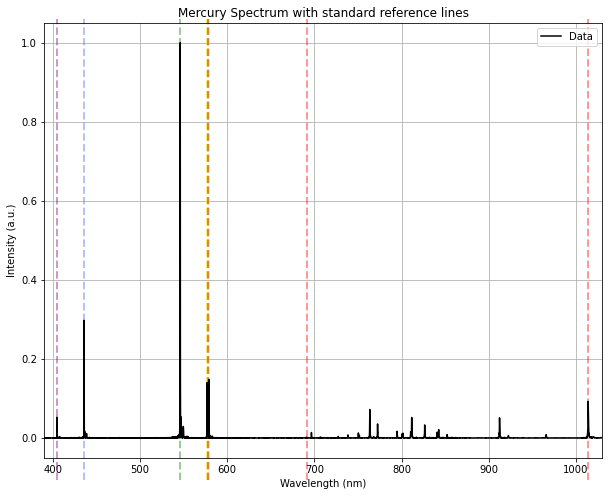

In [13]:
plt.rcParams["figure.figsize"] = (10,8)

alpha=0.4

plt.figure("Fully corrected spectrum FFT")
plt.title('Mercury Spectrum with standard reference lines')

plt.axvline(x=purple, ymin=-.05, ymax=1.01, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='purple')
plt.axvline(x=blue, ymin=-.05, ymax=1.01, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='royalblue')
plt.axvline(x=green, ymin=-.05, ymax=1.01,  linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='green')
plt.axvline(x=yellow1, ymin=-.05, ymax=1.01, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha*1.5, color='gold')
plt.axvline(x=yellow2, ymin=-.05, ymax=1.01, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha*1.5, color='gold')
plt.axvline(x=yellow_mean, ymin=-.05, ymax=1.01, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='darkred')
plt.axvline(x=red, ymin=-.05, ymax=1.01, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='red')
plt.axvline(x=infrared, ymin=-.05, ymax=1.01, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='red')

plt.plot(xvals, yvals, label='Data', color='black')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (a.u.)')
plt.xlim(390, 1030)  # change depending on where you expect to see spectra
plt.grid()
plt.legend()
plt.show()


## Plot with Experiment Determined Lines (basic version using peaks rather than fitting a curve)

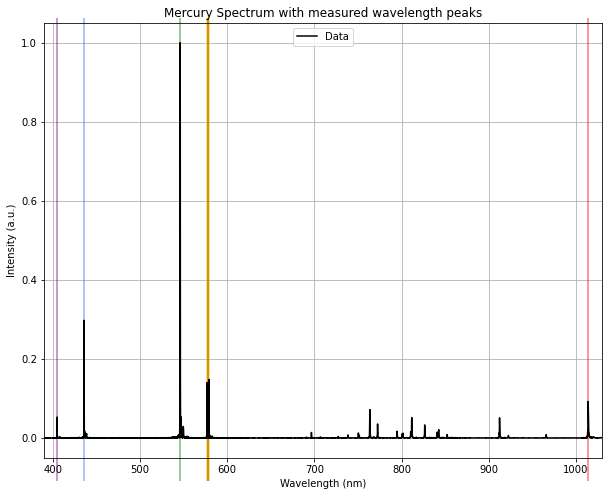

In [14]:
alpha2 = alpha*1
plt.figure("Fully corrected spectrum FFT")
plt.title('Mercury Spectrum with measured wavelength peaks')

plt.axvline(x=purple_wavelength, ymin=-.05, ymax=1.01, linewidth=2,clip_on =False, linestyle = '-', alpha=alpha2, color='purple')
plt.axvline(x=blue_wavelength, ymin=-.05, ymax=1.01, linewidth=2,clip_on =False, linestyle = '-', alpha=alpha2, color='royalblue')
plt.axvline(x=green_wavelength, ymin=-.05, ymax=1.01,  linewidth=2,clip_on =False, linestyle = '-', alpha=alpha2, color='green')
plt.axvline(x=yellow_wavelength1, ymin=-.05, ymax=1.01, linewidth=2,clip_on =False, linestyle = '-', alpha=alpha2*1.5, color='gold')
plt.axvline(x=yellow_wavelength2, ymin=-.05, ymax=1.01, linewidth=2,clip_on =False, linestyle = '-', alpha=alpha2*1.5, color='gold')
plt.axvline(x=yellow_mean_wavelength, ymin=-.05, ymax=1.01, linewidth=2,clip_on =False, linestyle = '-', alpha=alpha2, color='darkred')
# plt.axvline(x=red_wavelength, ymin=-.05, ymax=1.01, linewidth=2,clip_on =False, linestyle = '-', alpha=alpha2, color='red')
plt.axvline(x=ir_wavelength, ymin=-.05, ymax=1.01, linewidth=2,clip_on =False, linestyle = '-', alpha=alpha2, color='red')

plt.plot(xvals, yvals, label='Data', color='black')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (a.u.)')
plt.xlim(390, 1030)  # change depending on where you expect to see spectra
plt.grid()
plt.legend()
plt.show()


## Final print statements

In [15]:
def percentage_error(measured_wavelength, reference_wavelenght):
    return np.absolute(reference_wavelenght-measured_wavelength)*100/measured_wavelength

def final_print(color, measured_wavelength, reference_wavelenght):
    return print('The {0} peak is observed at {1:.2f} nm while the accepted value is {2:.2f}. This indicates an error of {3:.2f}%' .format(color,measured_wavelength,reference_wavelenght,percentage_error(measured_wavelength, reference_wavelenght)))

final_print('Purple',purple_wavelength,purple)
final_print('Blue',blue_wavelength,blue)
final_print('Green',green_wavelength,green)
final_print('Yellow1',yellow_wavelength1,yellow1)
final_print('Yellow2',yellow_wavelength2,yellow2)
final_print('Infrared',ir_wavelength,infrared)

The Purple peak is observed at 404.61 nm while the accepted value is 404.66. This indicates an error of 0.01%
The Blue peak is observed at 435.81 nm while the accepted value is 435.83. This indicates an error of 0.01%
The Green peak is observed at 546.03 nm while the accepted value is 546.07. This indicates an error of 0.01%
The Yellow1 peak is observed at 576.92 nm while the accepted value is 576.96. This indicates an error of 0.01%
The Yellow2 peak is observed at 579.03 nm while the accepted value is 579.07. This indicates an error of 0.01%
The Infrared peak is observed at 1013.89 nm while the accepted value is 1013.98. This indicates an error of 0.01%


## Final Plot for Report with Standard Reference Lines

In [16]:
# Figure Set Up

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset, inset_axes

alpha=0.4


fig = plt.figure(figsize = (12,8), dpi=1200)
ax = plt.subplot(111) #whole path

# fig, ax = plt.subplots()


# plt.figure("Fully corrected spectrum FFT")
ax.set_title('Mercury Spectrum with Standard Reference Lines')

#used for miniplots:
height=9200

# Custom Grid Lines
ax.axvline(x=425, ymin=0, ymax=0.75, linewidth=0.5, color='gray')
ax.axvline(x=450, ymin=0, ymax=0.75, linewidth=0.5, color='gray')
ax.axvline(x=475, ymin=0, ymax=0.75, linewidth=0.5, color='gray')
ax.axvline(x=500, ymin=0, ymax=0.75, linewidth=0.5, color='gray')
ax.axvline(x=525, ymin=0, ymax=0.75, linewidth=0.5, color='gray')
ax.axvline(x=550, ymin=0, ymax=0.75, linewidth=0.5, color='gray')
ax.axvline(x=575, ymin=0, ymax=0.75, linewidth=0.5, color='gray')
ax.axvline(x=600, ymin=0, ymax=0.75, linewidth=0.5, color='gray')

ax.axhline(y=0.25, xmin=0, xmax=1, linewidth=0.5, color='gray')
ax.axhline(y=0.5, xmin=0, xmax=1, linewidth=0.5, color='gray')
ax.axhline(y=0.75, xmin=0, xmax=1, linewidth=0.5, color='gray')
ax.axhline(y=1, xmin=0, xmax=1, linewidth=0.5, color='gray')

#Fourier Transform (FFT) Plot
ax.plot(xvals, yvals, label='Data', color='black')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity (a.u.)')
ax.set_xlim(400, 600)  # change depending on where you expect to see spectra
ax.set_ylim(0,1.4)
ax.set_yticks(np.arange(0,1.1,0.25))

#Mini Plots + Final Plot

#miniplot 1 - purple

axins = zoomed_inset_axes(ax,13, borderpad=1, bbox_to_anchor=[2700, height])
axins.plot(xvals, yvals, color='black')
axins.set_xlim(403.8,405.4)
axins.axvline(x=purple_wavelength, ymin=0, ymax=1, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='purple')
axins.set_ylim(-.004,0.06)
mark_inset(ax,axins,loc1=2,loc2=4, lw=0.5, ls='-.')
axins.set_xticks([round(purple_wavelength,2)])
axins.set_yticks([])


#miniplot 2 - blue

axins = zoomed_inset_axes(ax,6, borderpad=1, loc='upper center', bbox_to_anchor=[4000, height])
axins.plot(xvals, yvals, color='black')
axins.set_xlim(433.5,438)
axins.axvline(x=blue_wavelength, ymin=0, ymax=1, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='blue')
axins.set_ylim(-.004,0.13)
mark_inset(ax,axins,loc1=2,loc2=4, lw=0.5, ls='-.')
axins.set_xticks([round(blue_wavelength,2)])
axins.set_yticks([])


#miniplot 3a - green low

axins = zoomed_inset_axes(ax,5, borderpad=1, loc='upper center', bbox_to_anchor=[7900, height])
axins.plot(xvals, yvals, color='black')
axins.set_xlim(543,549)
axins.axvline(x=green_wavelength, ymin=0, ymax=1, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='green')
axins.set_ylim(-.004,0.25)
mark_inset(ax,axins,loc1=3,loc2=4, lw=0.5, ls='-.')
axins.set_xticks([round(green_wavelength,2)])
axins.set_yticks([])


#miniplot 3b - green high

axins = zoomed_inset_axes(ax,60, borderpad=1, loc='upper center', bbox_to_anchor=[9700, height])
axins.plot(xvals, yvals, color='black')
axins.set_xlim(545.9,546.15)
axins.axvline(x=green_wavelength, ymin=0, ymax=1, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='green')
axins.set_ylim(0.99,1.001)
mark_inset(ax,axins,loc1=4,loc2=1, lw=0.5, ls='-.')
axins.set_xticks([round(green_wavelength,2)])
axins.set_yticks([])


#miniplot 4 - yellows

axins = zoomed_inset_axes(ax,6, borderpad=1, bbox_to_anchor=[14000, height])
axins.plot(xvals, yvals, color='black')
axins.set_xlim(575,581)
axins.axvline(x=yellow_mean_wavelength, ymin=0, ymax=1, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='darkred')
axins.axvline(x=yellow_wavelength1, ymin=0, ymax=1, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha*1.5, color='darkgoldenrod')
axins.axvline(x=yellow_wavelength2, ymin=0, ymax=1, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha*1.5, color='darkgoldenrod')
axins.set_ylim(-.004,0.155)
mark_inset(ax,axins,loc1=3,loc2=4, lw=0.5, ls='-.')
axins.set_xticks([round(yellow_mean_wavelength,2)])
axins.set_yticks([])

plt.tight_layout()

# plt.savefig('report plot.png')
plt.show()


C:\Users\Maanas\AppData\Local\Temp\ipykernel_7216\4051537498.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


# Part 5 - Curve Fitting Each Spectral Line Using a Gaussian Function (Extension Task)

Set Up

In [17]:
#%%% curvefits 

def gaussian(x, amp, mu, sigma):
    return (amp * np.exp(-((x - mu) ** 2) / (2 * sigma** 2)))

def two_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    gauss1 = (amp1 * np.exp(-((x - mu1) ** 2) / (2 * sigma1** 2)))
    gauss2 = (amp2 * np.exp(-((x - mu2) ** 2) / (2 * sigma2** 2)))
    return gauss1+gauss2

df = pd.DataFrame({'x':xvals, 'y':yvals})


### Individual Curve Fits

#### Purple

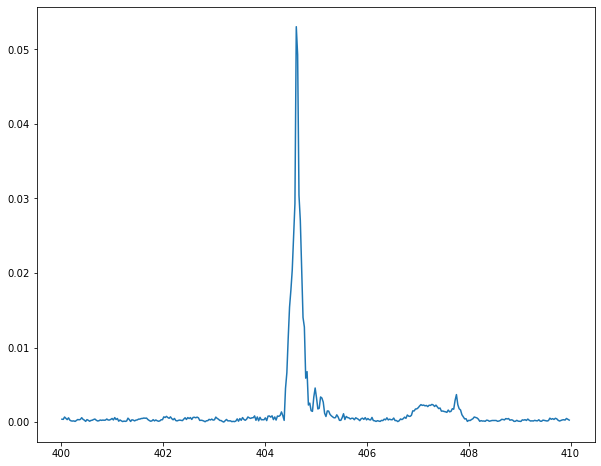

The parameters
[ 4.07041898e-02  4.04624437e+02 -8.93069182e-02]
------------------------------------------------------------------------------------------
The covariance matrix
[[ 5.31927214e-07  5.25239129e-11  7.78067368e-07]
 [ 5.25239129e-11  3.41431561e-06 -1.39196901e-09]
 [ 7.78067368e-07 -1.39196901e-09  3.41431462e-06]]
The signal parameters are
 Gaussian amplitude = 4.07042e-02 +/- 7.293e-04
 Peak position (mu) = 404.62444 +/- 0.002
 Gaussian width (sigma) = -0.08931 +/- 0.002


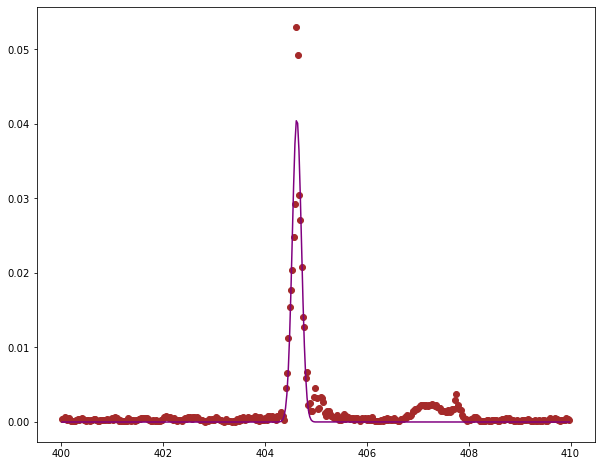

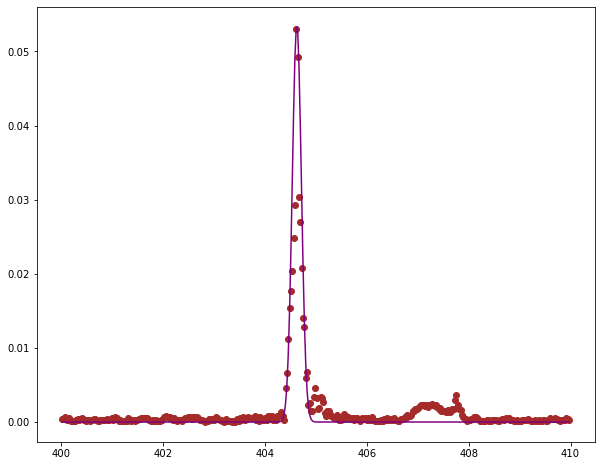

In [18]:
#%%%% purple

df_purple = df[(df.x > purple_min) & (df.x < purple_max)]

plt.plot(df_purple.x,df_purple.y)
plt.show()

#actual curve fit

amp_guess_purple = 0.051

mu_guess_purple = 400

sigma_guess_purple = 1

p0_purple = [amp_guess_purple, mu_guess_purple, sigma_guess_purple]

fit_purple,cov_purple = op.curve_fit(gaussian, df_purple.x,df_purple.y, p0_purple,maxfev = 1000000000)

print("The parameters")
print(fit_purple)
print('--'*45)
print('The covariance matrix')
print(cov_purple)

print("The signal parameters are")
print(" Gaussian amplitude = %.5e +/- %.3e" %(fit_purple[0],np.sqrt(cov_purple[0,0])))
print(" Peak position (mu) = %.5f +/- %.3f"%(fit_purple[1],np.sqrt(cov_purple[1,1])))
print(" Gaussian width (sigma) = %.5f +/- %.3f"%(fit_purple[2],np.sqrt(cov_purple[2,2])))

curve_fit_purple1=gaussian(df_purple.x, fit_purple[0], fit_purple[1], fit_purple[2])

plt.plot(df_purple.x,df_purple.y,'o', color='brown')
plt.plot(df_purple.x,curve_fit_purple1,color='purple')
plt.show()

#scaling the amplitude to fit more nicely 

curve_fit_purple2=gaussian(df_purple.x, fit_purple[0], fit_purple[1], fit_purple[2])

amp_scaling_purple = 1.32

plt.plot(df_purple.x,df_purple.y,'o', color='brown')
plt.plot(df_purple.x,amp_scaling_purple*curve_fit_purple2,color='purple')
plt.show()


#### Blue

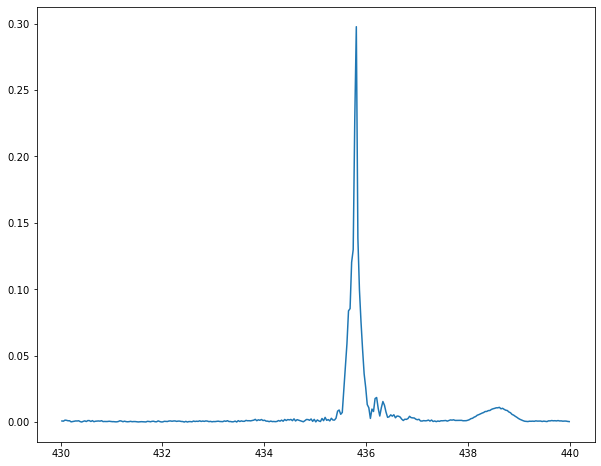

The parameters
[ 2.10888407e-01  4.35789120e+02 -8.29966037e-02]
------------------------------------------------------------------------------------------
The covariance matrix
[[ 2.17711291e-05  4.46949541e-10  5.71245672e-06]
 [ 4.46949541e-10  4.49662120e-06 -1.53693089e-09]
 [ 5.71245672e-06 -1.53693089e-09  4.49662028e-06]]
The signal parameters are
 Gaussian amplitude = 2.10888e-01 +/- 4.666e-03
 Peak position (mu) = 435.78912 +/- 0.002
 Gaussian width (sigma) = -0.08300 +/- 0.002


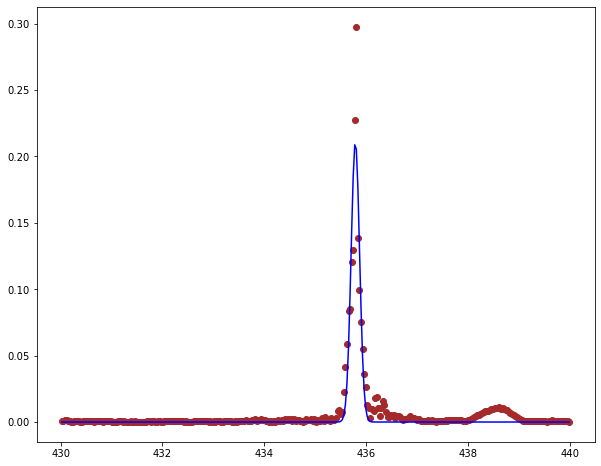

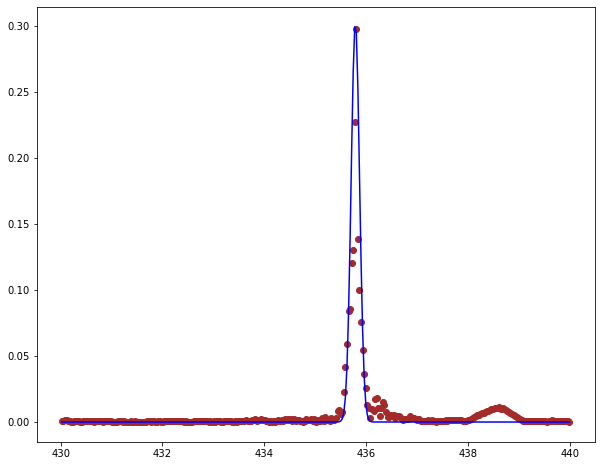

In [19]:
#%%%% blue

df_blue = df[(df.x > blue_min) & (df.x < blue_max)]

plt.plot(df_blue.x,df_blue.y)
plt.show()

#actual curve fit

amp_guess_blue = 0.3

mu_guess_blue = 436

sigma_guess_blue = 2

p0_blue = [amp_guess_blue, mu_guess_blue, sigma_guess_blue]

fit_blue,cov_blue = op.curve_fit(gaussian, df_blue.x,df_blue.y, p0_blue,maxfev = 1000000000)

print("The parameters")
print(fit_blue)
print('--'*45)
print('The covariance matrix')
print(cov_blue)

print("The signal parameters are")
print(" Gaussian amplitude = %.5e +/- %.3e" %(fit_blue[0],np.sqrt(cov_blue[0,0])))
print(" Peak position (mu) = %.5f +/- %.3f"%(fit_blue[1],np.sqrt(cov_blue[1,1])))
print(" Gaussian width (sigma) = %.5f +/- %.3f"%(fit_blue[2],np.sqrt(cov_blue[2,2])))

curve_fit_blue1=gaussian(df_blue.x, fit_blue[0], fit_blue[1], fit_blue[2])

plt.plot(df_blue.x,df_blue.y,'o', color='brown')
plt.plot(df_blue.x,curve_fit_blue1,color='blue')
plt.show()

#scaling the amplitude to fit more nicely 

curve_fit_blue2=gaussian(df_blue.x, fit_blue[0], fit_blue[1], fit_blue[2])

amp_scaling_blue = 1.433

plt.plot(df_blue.x,df_blue.y,'o', color='brown')
plt.plot(df_blue.x,amp_scaling_blue*curve_fit_blue2,color='blue')
plt.show()

#### Green

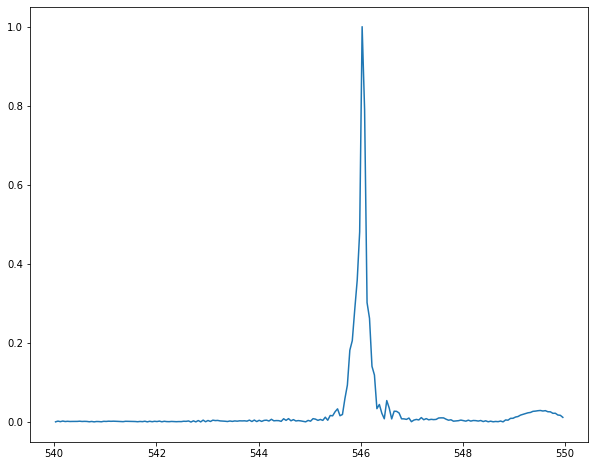

The parameters
[ 7.98660067e-01  5.46033796e+02 -9.18553814e-02]
------------------------------------------------------------------------------------------
The covariance matrix
[[ 4.72580766e-04  3.20972629e-09  3.62365145e-05]
 [ 3.20972629e-09  8.33562498e-06 -2.43540468e-09]
 [ 3.62365145e-05 -2.43540468e-09  8.33562369e-06]]
The signal parameters are
 Gaussian amplitude = 7.98660e-01 +/- 2.174e-02
 Peak position (mu) = 546.03380 +/- 0.003
 Gaussian width (sigma) = -0.09186 +/- 0.003


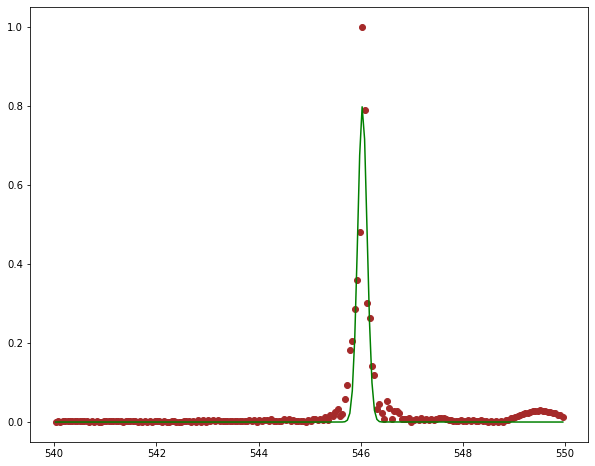

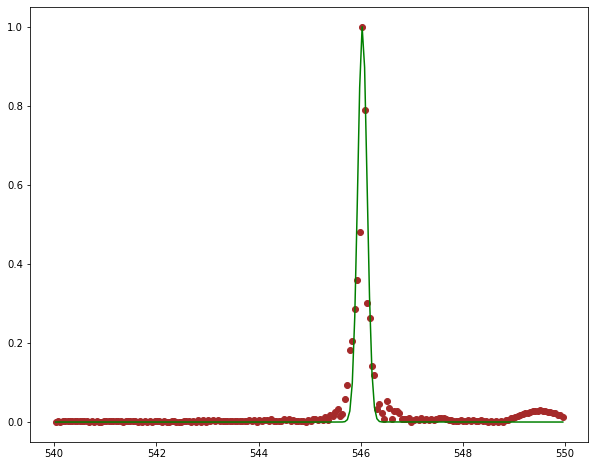

In [20]:
#%%%% green

df_green = df[(df.x > green_min) & (df.x < green_max)]

plt.plot(df_green.x,df_green.y)
plt.show()

#actual curve fit

amp_guess_green = 1

mu_guess_green = 546

sigma_guess_green = 10

p0_green = [amp_guess_green, mu_guess_green, sigma_guess_green]

fit_green,cov_green = op.curve_fit(gaussian, df_green.x,df_green.y, p0_green,maxfev = 1000000000)

print("The parameters")
print(fit_green)
print('--'*45)
print('The covariance matrix')
print(cov_green)

print("The signal parameters are")
print(" Gaussian amplitude = %.5e +/- %.3e" %(fit_green[0],np.sqrt(cov_green[0,0])))
print(" Peak position (mu) = %.5f +/- %.3f"%(fit_green[1],np.sqrt(cov_green[1,1])))
print(" Gaussian width (sigma) = %.5f +/- %.3f"%(fit_green[2],np.sqrt(cov_green[2,2])))

curve_fit_green1=gaussian(df_green.x, fit_green[0], fit_green[1], fit_green[2])

plt.plot(df_green.x,df_green.y,'o', color='brown')
plt.plot(df_green.x,curve_fit_green1,color='green')
plt.show()

#scaling the amplitude to fit more nicely 

curve_fit_green2=gaussian(df_green.x, fit_green[0], fit_green[1], fit_green[2])

amp_scaling_green = 1.25395

plt.plot(df_green.x,df_green.y,'o', color='brown')
plt.plot(df_green.x,amp_scaling_green*curve_fit_green2,color='green')
plt.show()



#### Double Yellow

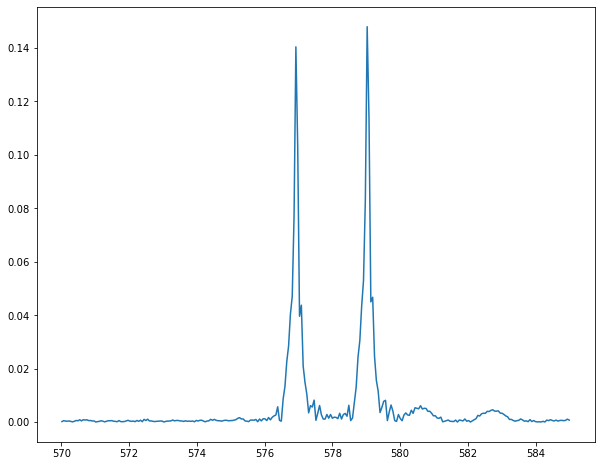

The parameters
[1.10141811e-01 5.76923787e+02 1.06354562e-01 1.17416379e-01
 5.79029153e+02 1.10254459e-01]
------------------------------------------------------------------------------------------
The covariance matrix
[[ 1.30543836e-05  6.79267748e-10 -8.40426433e-06  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 6.79267748e-10  1.62317173e-05  5.32888032e-09  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-8.40426433e-06  5.32888032e-09  1.62317136e-05  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.26852981e-05
   6.21411554e-10 -7.94103325e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.21411554e-10
   1.49133354e-05  5.09587011e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.94103325e-06
   5.09587011e-09  1.49133321e-05]]
The signal parameters are
 Gaussian amplitude for the first peak = 1.10142e-01 +/- 3.613e-03
 Peak position (mu) for the first peak = 576.92379 +/- 0.004
 Gaussian width (s

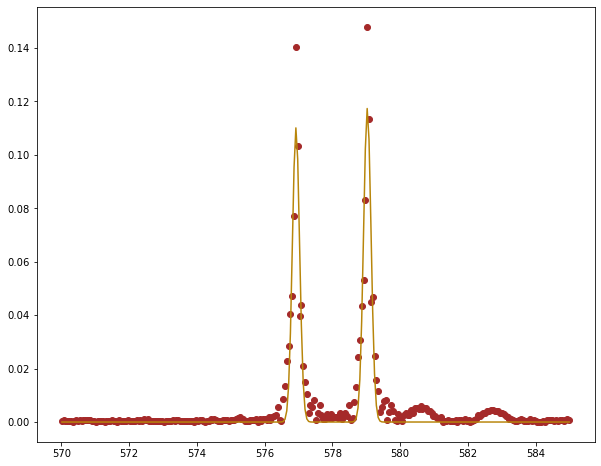

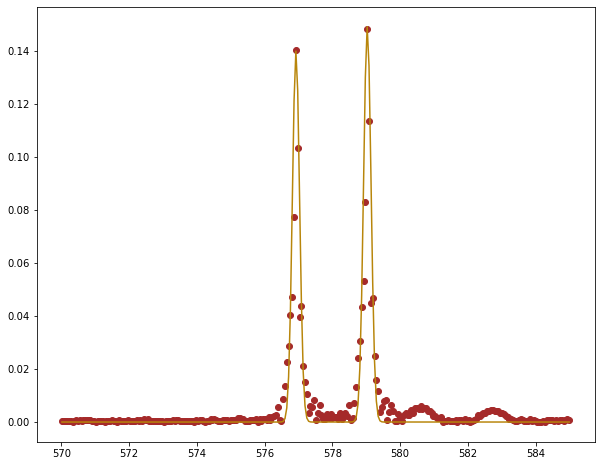

In [21]:
#%%%% yellow

df_yellow = df[(df.x > yellow_min) & (df.x < yellow_max)]

plt.plot(df_yellow.x,df_yellow.y)
plt.show()

#actual curve fit

amp_guess_yellow1 = 0.14

mu_guess_yellow1 = 576

sigma_guess_yellow1 = 0.1

amp_guess_yellow2 = 0.15

mu_guess_yellow2 = 579

sigma_guess_yellow2 = 0.1


p0_yellow = [amp_guess_yellow1, mu_guess_yellow1, sigma_guess_yellow1, amp_guess_yellow2, mu_guess_yellow2, sigma_guess_yellow2]

fit_yellow,cov_yellow = op.curve_fit(two_gaussian, df_yellow.x,df_yellow.y, p0_yellow,maxfev = 1000000000)

print("The parameters")
print(fit_yellow)
print('--'*45)
print('The covariance matrix')
print(cov_yellow)

print("The signal parameters are")
print(" Gaussian amplitude for the first peak = %.5e +/- %.3e" %(fit_yellow[0],np.sqrt(cov_yellow[0,0])))
print(" Peak position (mu) for the first peak = %.5f +/- %.3f"%(fit_yellow[1],np.sqrt(cov_yellow[1,1])))
print(" Gaussian width (sigma) for the first peak = %.5f +/- %.3f"%(fit_yellow[2],np.sqrt(cov_yellow[2,2])))

print('--'*45)

print(" Gaussian amplitude for the second peak = %.5e +/- %.3e" %(fit_yellow[3],np.sqrt(cov_yellow[3,3])))
print(" Peak position (mu) for the second peak = %.5f +/- %.3f"%(fit_yellow[4],np.sqrt(cov_yellow[4,4])))
print(" Gaussian width (sigma) for the second peak = %.5f +/- %.3f"%(fit_yellow[5],np.sqrt(cov_yellow[5,5])))

curve_fit_yellow1=two_gaussian(df_yellow.x, fit_yellow[0], fit_yellow[1], fit_yellow[2], fit_yellow[3], fit_yellow[4], fit_yellow[5])

plt.plot(df_yellow.x,df_yellow.y,'o', color='brown')
plt.plot(df_yellow.x,curve_fit_yellow1,color='darkgoldenrod')
plt.show()

#scaling the amplitude to fit more nicely 

curve_fit_yellow2=two_gaussian(df_yellow.x, fit_yellow[0], fit_yellow[1], fit_yellow[2], fit_yellow[3], fit_yellow[4], fit_yellow[5])

amp_scaling_yellow = 1.27

plt.plot(df_yellow.x,df_yellow.y,'o', color='brown')
plt.plot(df_yellow.x,amp_scaling_yellow*curve_fit_yellow2,color='darkgoldenrod')
plt.show()


## Plots For Report v2 - With Curvefits

In [22]:
#%%% plots for report v2 - with curvefits

# Set up

fig = plt.figure(figsize = (12,8), dpi=1200)
ax = plt.subplot(111) #whole path

# fig, ax = plt.subplots()


# plt.figure("Fully corrected spectrum FFT")
ax.set_title('Mercury Spectrum with Mean Measured Wavelengths')
# fig.suptitle('Mercury Spectrum with measured peak wavelengths')

height=9200


#Custom Grid Lines
ax.axvline(x=425, ymin=0, ymax=0.75, linewidth=0.5, color='gray')
ax.axvline(x=450, ymin=0, ymax=0.75, linewidth=0.5, color='gray')
ax.axvline(x=475, ymin=0, ymax=0.75, linewidth=0.5, color='gray')
ax.axvline(x=500, ymin=0, ymax=0.75, linewidth=0.5, color='gray')
ax.axvline(x=525, ymin=0, ymax=0.75, linewidth=0.5, color='gray')
ax.axvline(x=550, ymin=0, ymax=0.75, linewidth=0.5, color='gray')
ax.axvline(x=575, ymin=0, ymax=0.75, linewidth=0.5, color='gray')
ax.axvline(x=600, ymin=0, ymax=0.75, linewidth=0.5, color='gray')

ax.axhline(y=0.25, xmin=0, xmax=1, linewidth=0.5, color='gray')
ax.axhline(y=0.5, xmin=0, xmax=1, linewidth=0.5, color='gray')
ax.axhline(y=0.75, xmin=0, xmax=1, linewidth=0.5, color='gray')
ax.axhline(y=1, xmin=0, xmax=1, linewidth=0.5, color='gray')



#Fourier Transform Plot (Entire Specturm)
ax.plot(xvals, yvals, label='Data', color='black')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity (a.u.)')
ax.set_xlim(400, 600)  # change depending on where you expect to see spectra
ax.set_ylim(0,1.4)
ax.set_yticks(np.arange(0,1.1,0.25))



# Mini Plots + Final Plot

#miniplot 1 - purple

axins = zoomed_inset_axes(ax,13, borderpad=1, bbox_to_anchor=[2700, height])

axins.plot(xvals, yvals, 'x', color='black')
axins.plot(df_purple.x,amp_scaling_purple*curve_fit_purple2,color='purple')
axins.axvline(x=fit_purple[1], ymin=0, ymax=1, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='purple')

mark_inset(ax,axins,loc1=2,loc2=4, lw=0.5, ls='-.')
axins.set_xticks([round(fit_purple[1],2)])
axins.set_yticks([])
axins.set_xlim(403.8,405.4)
axins.set_ylim(-.004,0.06)


#miniplot 2 - blue

axins = zoomed_inset_axes(ax,6, borderpad=1, loc='upper center', bbox_to_anchor=[4000, height])

axins.plot(xvals, yvals, 'x', color='black')
axins.plot(df_blue.x,amp_scaling_blue*curve_fit_blue2,color='blue')
axins.axvline(x=fit_blue[1], ymin=0, ymax=1, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='blue')

axins.set_xlim(433.5,438)
axins.set_ylim(-.004,0.15)
mark_inset(ax,axins,loc1=2,loc2=4, lw=0.5, ls='-.')
axins.set_xticks([round(fit_blue[1],2)])
axins.set_yticks([])


#miniplot 3a - green low

axins = zoomed_inset_axes(ax,5, borderpad=1, loc='upper center', bbox_to_anchor=[7900, height])

axins.plot(xvals, yvals, 'x', color='black')
axins.plot(df_green.x,amp_scaling_green*curve_fit_green2,color='green')
axins.axvline(x=fit_green[1], ymin=0, ymax=1, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='green')

axins.set_xlim(543,549)
axins.set_ylim(-.004,0.25)
mark_inset(ax,axins,loc1=3,loc2=4, lw=0.5, ls='-.')
axins.set_xticks([round(fit_green[1],2)])
axins.set_yticks([])


#miniplot 3b - green high

axins = zoomed_inset_axes(ax,60, borderpad=1, loc='upper center', bbox_to_anchor=[9700, height])

axins.plot(xvals, yvals, 'x', color='black')
axins.plot(df_green.x,amp_scaling_green*curve_fit_green2,color='green')
axins.axvline(x=fit_green[1], ymin=0, ymax=1, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='green')

axins.set_xlim(545.9,546.15)
axins.set_ylim(0.99,1.002)
mark_inset(ax,axins,loc1=4,loc2=1, lw=0.5, ls='-.')
axins.set_xticks([round(fit_green[1],2)])
axins.set_yticks([])


#miniplot 4 - yellows

axins = zoomed_inset_axes(ax,6, borderpad=1, bbox_to_anchor=[14000, height])

axins.plot(xvals, yvals, 'x', color='black')
axins.plot(df_yellow.x,amp_scaling_yellow*curve_fit_yellow2,color='darkgoldenrod')
axins.axvline(x=fit_yellow[1], ymin=0, ymax=1, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='darkgoldenrod')
axins.axvline(x=fit_yellow[4], ymin=0, ymax=1, linewidth=2,clip_on =False, linestyle = '--', alpha=alpha, color='darkgoldenrod')

axins.set_xlim(575,581)
axins.set_ylim(-.004,0.155)
mark_inset(ax,axins,loc1=3,loc2=4, lw=0.5, ls='-.')
axins.set_xticks([round(fit_yellow[1],2), round(fit_yellow[4],2)])
axins.set_yticks([])

plt.tight_layout()

# plt.savefig('report plot2.png')
plt.show()


C:\Users\Maanas\AppData\Local\Temp\ipykernel_7216\2145827515.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [23]:
print("The End!")

The End!
